In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math

#Get the ISO-Codes
iso = pd.read_csv("../Data/ISO/ISO.csv")

In [2]:
# --- : Load DataFrames from CSV ---
print("\nLoading W_ij Dataframes from CSV files...")
W_ij_dataframes = {}
csv_filenames = ['../Data/Networks/W_1_ij.csv', '../Data/Networks/W_2_ij.csv', '../Data/Networks/W_3_ij.csv']
for filename in csv_filenames:
    try:
        df_reloaded = pd.read_csv(filename)
        base_name = os.path.basename(filename) # Gets 'W_1_ij.csv'
        parts = base_name.split('_') # Splits into ['W', '1', 'ij.csv']
        
        # Check if the parts list has at least 2 elements and the second part is a number
        if len(parts) >= 2 and parts[1].isdigit():
            df_number = parts[1]
            new_df_name = f"W_{df_number}_ij"
        else:
            # Fallback if filename format is unexpected, or use the full name as before
            new_df_name = os.path.splitext(base_name)[0] 
            
        W_ij_dataframes[new_df_name] = df_reloaded
        print(f"Loaded {filename} as {new_df_name}")
    except Exception as e:
        print(f"Error loading {filename}: {e}")


Loading W_ij Dataframes from CSV files...
Loaded ../Data/Networks/W_1_ij.csv as W_1_ij
Loaded ../Data/Networks/W_2_ij.csv as W_2_ij
Loaded ../Data/Networks/W_3_ij.csv as W_3_ij


In [3]:
# Define the desired start and end periods for filtering
start_period = 1989 
end_period = 2020  

print(f"\nFiltering DataFrames for periods between {start_period} and {end_period}...")
# Iterate through the dictionary and filter dataframes in-place
for df_name, df_content in W_ij_dataframes.items():
    if not df_content.empty and 'period' in df_content.columns:
        # Apply the period filter directly to the DataFrame in the dictionary
        original_rows = len(df_content)
        W_ij_dataframes[df_name] = df_content[(df_content['period'] >= start_period) & (df_content['period'] <= end_period)]
        print(f"Filtered {df_name}. Original rows: {original_rows}, Filtered rows: {len(W_ij_dataframes[df_name])}")
    else:
        print(f"Skipping filtering for {df_name}: DataFrame is empty or 'period' column is missing.")



Filtering DataFrames for periods between 1989 and 2020...
Filtered W_1_ij. Original rows: 31911, Filtered rows: 27179
Filtered W_2_ij. Original rows: 12271, Filtered rows: 10586
Filtered W_3_ij. Original rows: 94337, Filtered rows: 78649



PageRank for 2002:
   Country  PageRank
0      FRA  0.101990
1      JPN  0.080557
2      USA  0.076514
3      GBR  0.050892
4      CHN  0.049805
5      DEU  0.048636
6      _X   0.042513
7      SGP  0.029240
8      AUT  0.028134
9      ITA  0.025295
10     MYS  0.022587
11     SUN  0.022540
12     NLD  0.019748
13     CHE  0.019674
14     S19  0.018011
15     CAN  0.017770
16     BEL  0.016726
17     BRA  0.016703
18     IND  0.016349
19     HKG  0.016121
20     AUS  0.016104
21     ESP  0.015916
22     DDR  0.015801
23     KOR  0.015588
24     ROU  0.015579
25     FIN  0.015537
26     NOR  0.015513
27     BMU  0.015470
28     CYP  0.015469
29     DNK  0.015469
30     ISL  0.015469
31     IDN  0.015469
32     GRC  0.015469
33     NZL  0.015469
34     PRY  0.015469
35     PRT  0.015469
36     TUR  0.015469
37     THA  0.015469


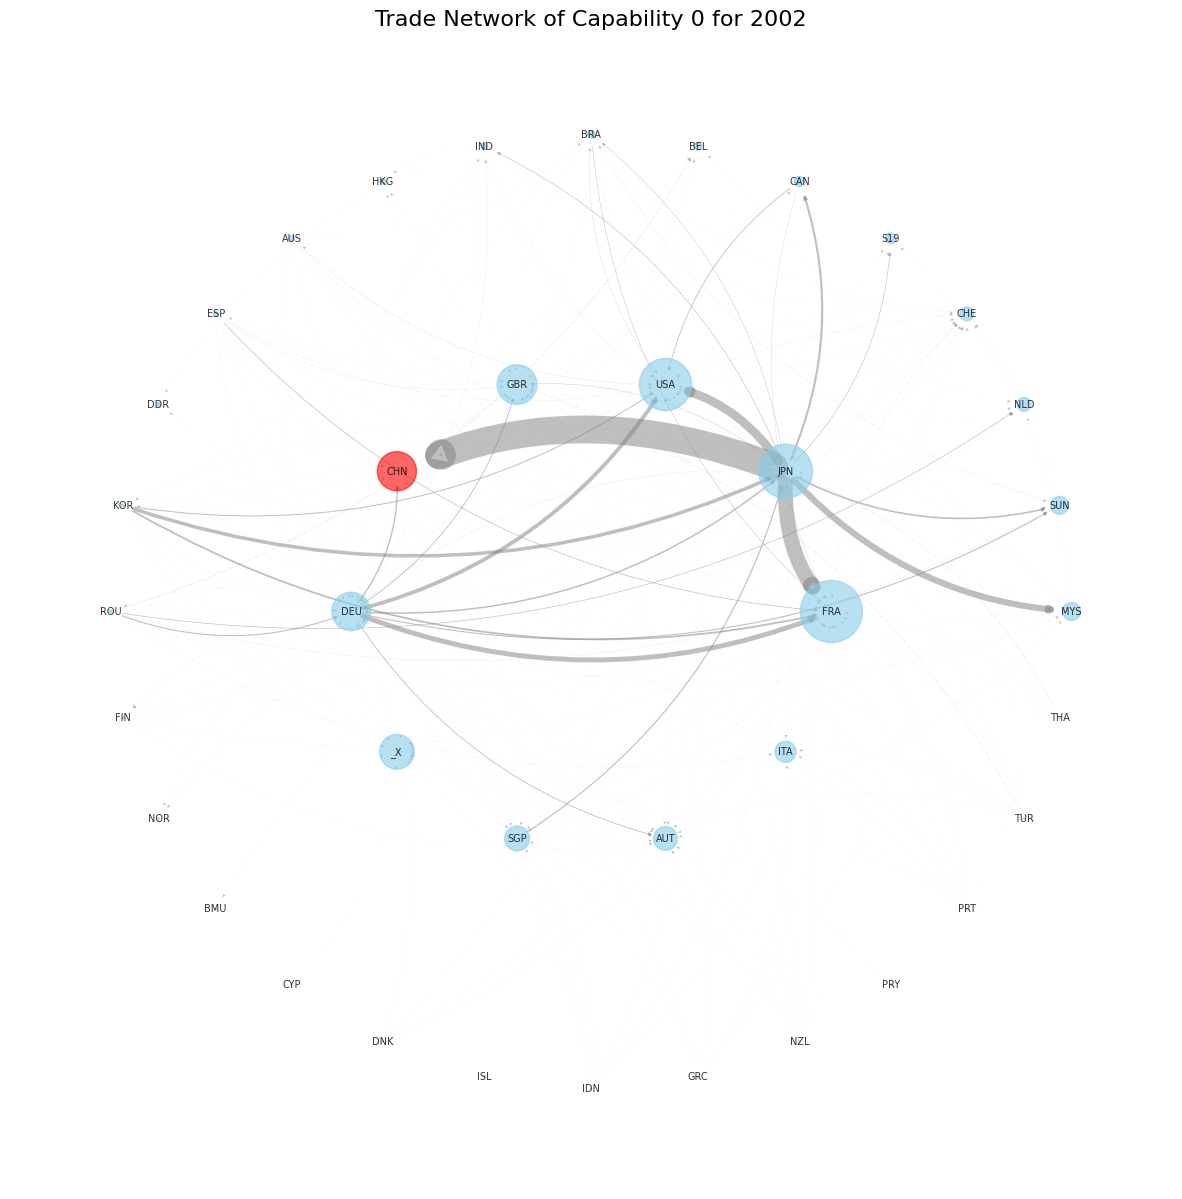

In [ ]:
# --- 1. PageRank Calculation for a Single Period ---
def calculate_pagerank(TN_t_c):
    """Calculates PageRank for a given period's DataFrame slice."""
    edges = TN_t_c[['reporterISO', 'partnerISO', 'W_ij']]

    countries = sorted(list(set(edges['reporterISO']).union(edges['partnerISO'])))
    country_index = {country: i for i, country in enumerate(countries)}
    n = len(countries)

    if n == 0:
        return pd.DataFrame(columns=['Country', 'PageRank']) # Return empty if no nodes

    W = np.zeros((n, n))
    for index, row in edges.iterrows():
        i = country_index[row['reporterISO']]
        j = country_index[row['partnerISO']]
        W[i, j] += row['W_ij']

    row_sums = W.sum(axis=1)
    dangling_nodes_mask = (row_sums == 0)

    M_row_stochastic = np.divide(W, row_sums[:, np.newaxis], where=row_sums[:, np.newaxis] != 0)
    if np.sum(dangling_nodes_mask) > 0:
        M_row_stochastic[dangling_nodes_mask, :] = 1.0 / n

    P = M_row_stochastic.T # Column-stochastic matrix for PageRank

    alpha = 0.85
    v = np.ones(n) / n
    r = np.ones(n) / n
    epsilon = 1e-8
    delta = 1.0
    iteration = 0
    max_iterations = 1000

    while delta > epsilon and iteration < max_iterations:
        r_new = alpha * P @ r + (1 - alpha) * v
        delta = np.linalg.norm(r_new - r, 1)
        r = r_new
        iteration += 1
    
    pagerank_t_c = pd.DataFrame({
        'Country': countries,
        'PageRank': r
    }).sort_values(by='PageRank', ascending=False).reset_index(drop=True)
    
    return pagerank_t_c



# --- 2. Create Custom Layout and Visualization ---
def visualize_network(TN_t_c, pagerank_t_c, top_n=10, period_val=2000, cap=0):
    G = nx.DiGraph()

    # Add edges with weights
    for index, row in TN_t_c.iterrows():
        reporter = row['reporterISO']
        partner = row['partnerISO']
        weight = row['W_ij']
        G.add_edge(reporter, partner, weight=weight)

    if not G.nodes():
        print(f"No network data found for period {period_val}. Cannot visualize.")
        return

    # Filter out nodes from PageRank_df that are not in the current graph
    # This can happen if some countries are in pagerank_df but not active in the current df_period
    # (though for this specific function call, it should be consistent)
    active_nodes = list(G.nodes())
    pagerank_t_c_active = pagerank_t_c[pagerank_t_c['Country'].isin(active_nodes)].copy()

    # Identify top N and other countries
    if len(pagerank_t_c_active) > top_n:
        top_countries_df = pagerank_t_c_active.head(top_n)
        other_countries_df = pagerank_t_c_active.iloc[top_n:].copy()
        # Sort others by PageRank for consistent circle order
        other_countries_df = other_countries_df.sort_values(by='PageRank', ascending=False)
    else:
        # If fewer than top_n countries, all are considered "top" and will be centered
        top_countries_df = pagerank_t_c_active
        other_countries_df = pd.DataFrame(columns=['Country', 'PageRank']) # Empty

    # --- Calculate Custom Positions ---
    pos = {}
    
    # Parameters for layout
    center_radius = 1  # Radius for the central cluster
    outer_radius = 2.0   # Radius for the outer circle
    num_top = len(top_countries_df)
    num_others = len(other_countries_df)

    # Position for top countries (small circle in the center)
    for i, country in enumerate(top_countries_df['Country']):
        angle = 2 * math.pi * i / num_top if num_top > 0 else 0
        x = center_radius * math.cos(angle)
        y = center_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # Position for other countries (larger circle)
    for i, country in enumerate(other_countries_df['Country']):
        angle = 2 * math.pi * i / num_others if num_others > 0 else 0
        x = outer_radius * math.cos(angle)
        y = outer_radius * math.sin(angle)
        pos[country] = np.array([x, y])

    # --- Drawing ---
    plt.figure(figsize=(15, 15))

    # Node sizes 
    node_pageranks = pagerank_t_c_active.set_index('Country')['PageRank']
    max_pr = node_pageranks.max() #Get maximum PageRank
    min_pr = node_pageranks.min() #Get minimum PageRank
    
    # Scale node size for better visibility, making higher PR nodes larger
    node_sizes = [
        1 + 2000 * ((node_pageranks[node] - min_pr) / (max_pr - min_pr + 1e-9))
        for node in G.nodes()
    ] if len(node_pageranks) > 1 else [2000 for _ in G.nodes()]


    # Node colors: Differentiate top countries
    node_colors = ['red' if node == "CHN" else 'skyblue' for node in G.nodes()]

    # Edge widths based on W_ij
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    min_weight = min(edge_weights) if edge_weights else 0

    # Scale edge width for better visibility
    edge_widths = [
        0.01 + 20 * ((w - min_weight) / (max_weight - min_weight + 1e-9))
        for w in edge_weights
    ] if len(edge_weights) > 1 else [2.0 for _ in G.edges()]
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.6)

    # Draw edges
    nx.draw_networkx_edges(
    G, pos,
    edgelist=G.edges(),
    edge_color='grey',
    arrows=True,
    arrowstyle='-|>',
    arrowsize=5,  # Increased for better visibility
    width=edge_widths,
    connectionstyle="arc3,rad=0.2",  # More curve
    alpha=0.5,
    min_source_margin=0,
    min_target_margin=10
    )

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=7, font_weight="normal", alpha=0.8)

    plt.title(f'Trade Network of Capability {cap} for {period_val}', size=16)
    plt.axis('off') # Hide axes
    plt.show()




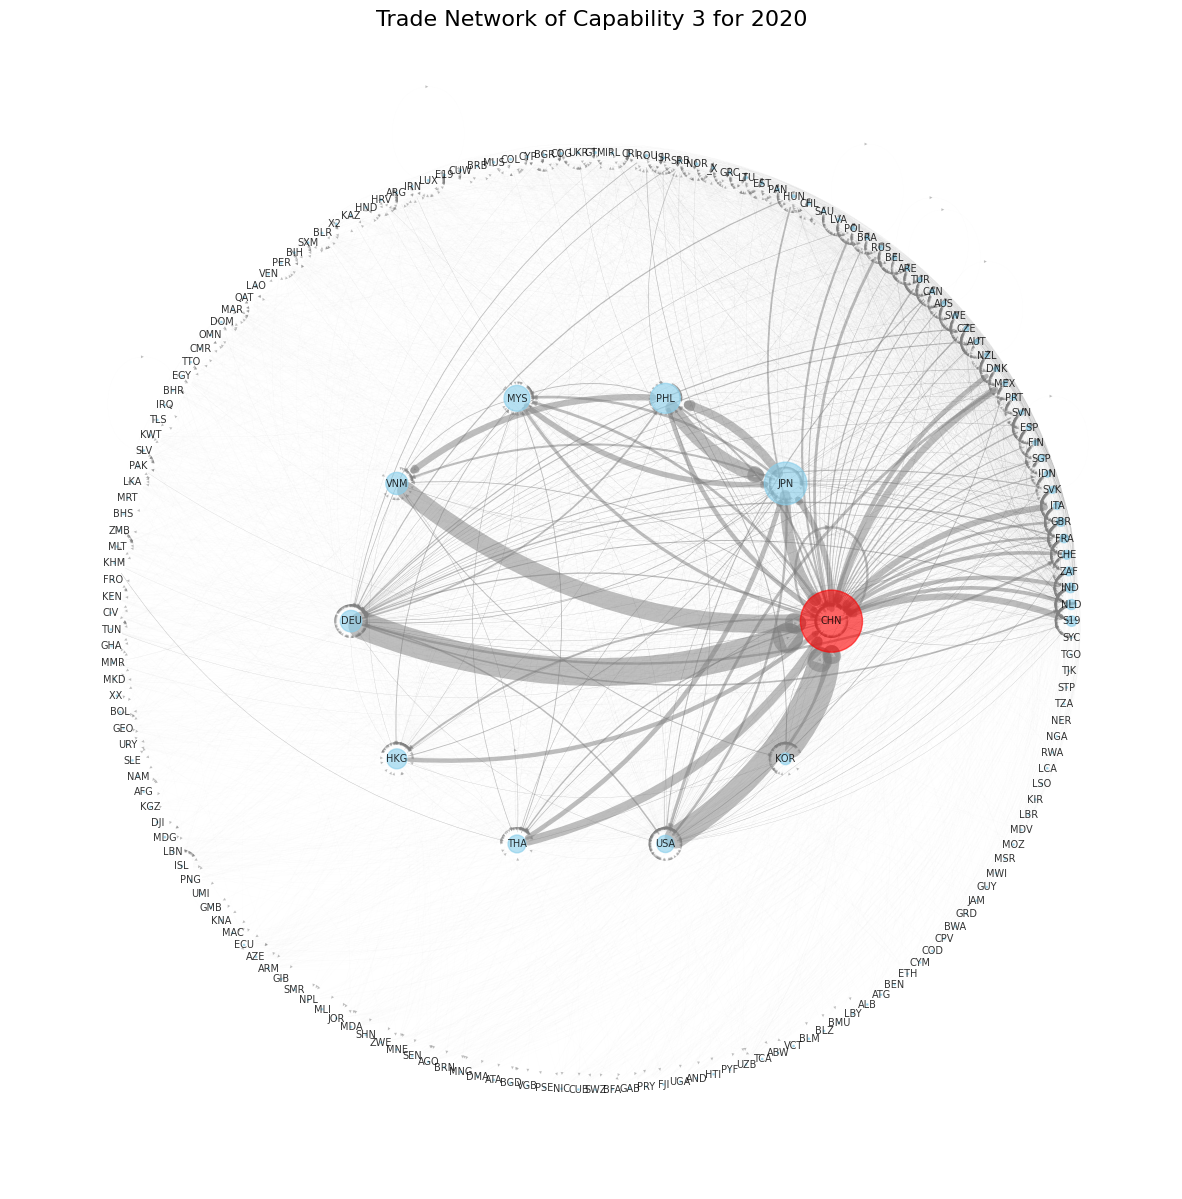

In [22]:
period_val = 2020
cap = 3

#Explanatory Dataframe of Cap 1
TN_t_c = W_ij_dataframes[f"W_{cap}_ij"][W_ij_dataframes[f"W_{cap}_ij"]["period"] == period_val]

#Calculate PageRank
pagerank_TN_t_c= calculate_pagerank(TN_t_c)

# Visualize the 2002 network with custom layout
visualize_network(TN_t_c, pagerank_TN_t_c, top_n=10, period_val = period_val, cap=cap) # Adjusted top_n to 3 due to small sample size